In [ ]:
#
# NPS comment analysis using NLTK
# Author: Eric G. Suchanek, PhD
# (c) 2022 BestBuy, All Rights Reserved
# Confidential, do not share

### Using Natural Language Processing to better understand NPS Survey Results

In [1]:

#Data management
import pandas as pd
import numpy as np
import re

#TextBlob Features
from textblob import TextBlob

#Plotting
import matplotlib.pyplot as plt

#SciKit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

#Tensorflow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

#Test
from collections import Counter
import bby
import bby.util as ut

np.random.seed(0)


In [2]:
import string
from nltk.corpus import stopwords

# Word frequency distributions
def nps_freqs(stringlist, howmany=0):
    Vocab_str = str()
    Vocab_str = " ".join(str(review).lower() for review in stringlist)

    docSplit = Vocab_str.split()
    freq = nltk.FreqDist(w for w in docSplit)
    return freq

def update_vocab(vocab, new_words):
    vocab.update(new_words)
    return

def make_vocab(_vocab, sent, stop_words):
    vocab = _vocab
    word_tokens = word_tokenize(sent)
    for w in word_tokens:
        if (len(w) > 2 and w not in stop_words):
            vocab.update(w)
    return vocab

def build_vocabulary(sent_list, stop_words):
    vocab = set()
    for sent in sent_list:
        vocab = make_vocab(vocab, sent, stop_words)
    return vocab

def make_vocab_strings(stringlist):
    Vocab_str = str()
    Vocab_str = " ".join(str(comment).lower() for comment in stringlist)
    return Vocab_str

                                         
def nps_cleanstring(comment):
    STOP_english = Counter(stopwords.words()) # Here we use a Counter dictionary on the cached
    Vocab_str = comment.lower()
    
    # print(f'Vocab_string <{Vocab_str}>')
    
    res = Vocab_str.translate(str.maketrans('', '', string.punctuation)) #removes [!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~]:
    docWords = res.split()
    filtered_sentence = [w for w in docWords if not w.lower() in STOP_english and len(w) > 1]
    
    ls = " ".join(filtered_sentence)
    return ls


Read file ../data/clean/NPS_NATL_cleaned.csv containing a total of: 107625 records.
Promoters: 92458, Passives: 6612, Detractors: 8555


<BarContainer object of 3 artists>

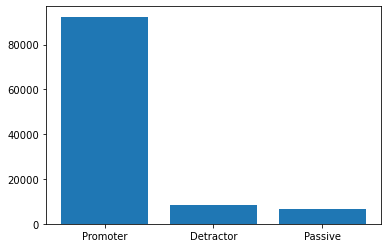

In [3]:
# National NPS extract processed by CleanNPS_National.py - this cleans and lemmatises the NPS and Overall
# comments. The full extract has not been equalized for comment distribution
# 

all_path = "../data/clean/NPS_NATL_cleaned.csv"
NPS_df = pd.read_csv(all_path)

prom_list_mask = NPS_df['NPS_Code'] == 2
pass_list_mask = NPS_df['NPS_Code'] == 1
det_list_mask = NPS_df['NPS_Code'] == 0

prom_df = NPS_df[prom_list_mask].copy()
pass_df = NPS_df[pass_list_mask].copy()
det_df = NPS_df[det_list_mask].copy()

prom_df_len = prom_df.shape[0]
pass_df_len = pass_df.shape[0]
det_df_len = det_df.shape[0]


prom_list_strings = prom_df['NPSCommentCleaned'].values.tolist()
pass_list_strings = pass_df['NPSCommentCleaned'].values.tolist()
det_list_strings = det_df['NPSCommentCleaned'].values.tolist()

prom_df.to_csv('../data/clean/prom_list.csv', index=False)
pass_df.to_csv('../data/clean/pass_list.csv', index=False)
det_df.to_csv('../data/clean/det_list.csv', index=False)

print(f'Read file {all_path} containing a total of: {NPS_df.shape[0]} records.')
print (f'Promoters: {prom_df_len}, Passives: {pass_df_len}, Detractors: {det_df_len}')

# Rechecking balance of target classes after equalization
sentiments = list(NPS_df["NPS® Breakdown"].unique())
#sentiment_nums = [len(NPS_df[NPS_df["NPS® Breakdown"] == sentiment]) / len(NPS_df) for sentiment in sentiments]
sentiment_nums = [len(NPS_df[NPS_df["NPS® Breakdown"] == sentiment]) for sentiment in sentiments]

plt.bar(sentiments, sentiment_nums)



In [4]:
#
# Build vocabularies for the different classes.
#
from wordcloud import WordCloud, STOPWORDS
from itertools import repeat
from itertools import takewhile

# I know that the following words are common across all classes so we strip them out in order to
# unbias the results

GS_stopwords = ['geek', 'squad', 'service', 'customer', 'xyxyxz','\'']

stop_GS = Counter(stopwords.words())
stop_GS.update(GS_stopwords)
                                      
replacements = dict(zip((fr'\b{word}\b' for word in stop_GS), repeat("")))

# remove the geeksquad 'stopwords' from the dataframes verbatim comments
# need for proper frequency analysis

print('Removing GS stopwords from promoters.')
prom_df.NPSCommentCleaned.replace(replacements, regex=True, inplace=True)
prom_df.NPSCommentCleaned.replace({r' +': ' ', r' +\.': '.'}, regex=True, inplace=True)

print('Removing GS stopwords from passives.')
pass_df.NPSCommentCleaned.replace(replacements, regex=True, inplace=True)
pass_df.NPSCommentCleaned.replace({r' +': ' ', r' +\.': '.'}, regex=True, inplace=True)

print('Removing GS stopwords from detractors.')
det_df.NPSCommentCleaned.replace(replacements, regex=True, inplace=True)
det_df.NPSCommentCleaned.replace({r' +': ' ', r' +\.': '.'}, regex=True, inplace=True)


print('Building Promoter vocabulary')
prom_strings = make_vocab_strings(prom_list_strings)
prom_vocab = build_vocabulary(prom_strings, stop_GS)

print('Building Passive vocabulary')
pass_strings = make_vocab_strings(pass_list_strings)
pass_vocab = build_vocabulary(pass_strings, stop_GS)

print('Building Detractor vocabulary')
det_strings = make_vocab_strings(det_list_strings)
det_vocab = build_vocabulary(det_strings, stop_GS)


Removing GS stopwords from promoters.


In [ ]:
gs = 'geek' in stop_GS
print(f'{gs}')

gs = 'geek' in prom_vocab
print(f'{gs}')
prom_vocab.update(['geek', 'squad', 'service', 'customer', 'service', 'xyxyxz','\''])

gs = 'geek' in prom_vocab
print(f'{gs}')

gs = 'geek' in pass_vocab
print(f'{gs}')
pass_vocab.update(['geek', 'squad', 'service', 'customer', 'service', 'xyxyxz','\''])

det_vocab.update(['geek', 'squad', 'service', 'customer', 'service', 'xyxyxz','\''])

gs = 'geek' in det_vocab
print(f'{gs}')



In [ ]:
# Promoters only
Freqs_prom = nps_freqs(prom_list_strings)
#Freqs_prom = nps_freqs(prom_strings)

Freqs_prom.plot(20)
topWords_prom = Freqs_prom.most_common(10)

# Freqs_prom.tabulate(20)

In [ ]:
# Passives only
Freqs_pass = nps_freqs(pass_list_strings)
Freqs_pass.plot(10)
topWords_pass = Freqs_pass.most_common(20)

Freqs_pass.tabulate(20)

In [ ]:
# Detractors only
Freqs_det = nps_freqs(det_list_strings)
Freqs_det.plot(10)
topWords_det = Freqs_det.most_common(25)

#Freqs_det.tabulate(50)


In [ ]:
from PIL import Image
import numpy as np
#im = Image.open("promoters1.png")
#bg_pic = np.asarray(im)


wordcloud_prom = WordCloud(width = 1280, height = 1024,
                #mask=bg_pic,
                background_color ='white',
                contour_color='black',
                contour_width=1,
                stopwords = stop_GS,
                collocations=False,
                min_font_size = 4).generate(prom_strings)
wordcloud_prom.to_file('promoters.png')
 
# plot the WordCloud image                      
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud_prom)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


In [ ]:
wordcloud_pass = WordCloud(width = 1280, height = 1024,
                background_color ='white',
                stopwords = stop_GS,
                collocations=False,
                min_font_size = 4).generate(prom_strings)

wordcloud_prom.to_file('passive.png')

# plot the WordCloud image                      
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud_pass)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()


In [ ]:
wordcloud_det = WordCloud(width = 1280, height = 1024,
                background_color ='white',
                stopwords = stop_GS,
                collocations=True,
                min_font_size = 4).generate(det_strings)
wordcloud_det.to_file('detractors.png')

 
# plot the WordCloud image                      
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud_det)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [ ]:
# Look at Bigrams across Promoters/Passives/Detractors

from nltk.collocations import BigramCollocationFinder, TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures, TrigramAssocMeasures
from nltk.corpus import stopwords

bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
fourgram_measures = nltk.collocations.QuadgramAssocMeasures()

topnumb = 10
stopset = set(stopwords.words('english'))
stopset.update(['best', 'buy', 'geek', 'squad', 'customer', 'service', 'xyxyxz','\''])
filter_stops = lambda w: len(w) < 3 or w in stopset

words = " ".join(str(comment).lower() for comment in prom_df.NPSCommentCleaned)
# wt = word_tokenize(words)
wt = nltk.wordpunct_tokenize(words)

# bigrams - promoters
bcf_prom = BigramCollocationFinder.from_words(wt)
bcf_prom.apply_word_filter(filter_stops)
bigrams_proms = bcf_prom.nbest(BigramAssocMeasures.likelihood_ratio, topnumb)
scored_bigrams_proms = bcf_prom.score_ngrams(bigram_measures.raw_freq)

# trigrams - promoters
tcf_prom = TrigramCollocationFinder.from_words(wt)
tcf_prom.apply_word_filter(filter_stops)
trigrams_proms = tcf_prom.nbest(TrigramAssocMeasures.likelihood_ratio, topnumb)

# bigrams - passives
words2 = " ".join(str(comment).lower() for comment in pass_df.NPSCommentCleaned)
wt = word_tokenize(words2)
bcf_pass = BigramCollocationFinder.from_words(wt)
bcf_pass.apply_word_filter(filter_stops)
bigrams_pass = bcf_pass.nbest(BigramAssocMeasures.likelihood_ratio, topnumb)

# trigrams - passives
tcf_pass = TrigramCollocationFinder.from_words(wt)
tcf_pass.apply_word_filter(filter_stops)
trigrams_pass = tcf_pass.nbest(TrigramAssocMeasures.likelihood_ratio, topnumb)

# bigrams - detractors
words3 = " ".join(str(comment).lower() for comment in det_df.NPSCommentCleaned)
wt = word_tokenize(words3)
bcf_det = BigramCollocationFinder.from_words(wt)
bcf_det.apply_word_filter(filter_stops)
bigrams_det = bcf_det.nbest(BigramAssocMeasures.likelihood_ratio, topnumb)

# trigrams - detractors
tcf_det = TrigramCollocationFinder.from_words(wt)
tcf_det.apply_word_filter(filter_stops)
trigrams_det = tcf_det.nbest(TrigramAssocMeasures.likelihood_ratio, topnumb)



In [ ]:
def print_ngram(ngrams, label):
    print(f'{label}')
    for ng in ngrams:
        wordstring = ''
        for w in ng:
            wordstring += str(w)
            wordstring += " "
        print(wordstring)
    return

print_ngram(bigrams_proms, "Promoter Bigrams: ")
print('-------------')
print_ngram(trigrams_proms, "Promoter Trigrams: ")
print('*************')
print('')

print_ngram(bigrams_pass, "Passive Bigrams: ")
print('-------------')
print_ngram(trigrams_pass, "Passive Trigrams: ")
print('*************')
print('')

print_ngram(bigrams_det, "Detractor Bigrams: ")
print('-------------')
print_ngram(trigrams_det, "Detractor Trigrams: ")
